<a href="https://colab.research.google.com/github/hmin27/2023_DL_Clip/blob/main/CLIP(Finetune)_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Fine tuning (FSL)
- Image classification with 4shot dataset
- Hyperparameter Tuning
  (Batch size, Learning Rate, Momentum, Weight Decay)
- Evaluating with Validation set(Top k accuracy)


In [61]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [62]:
import os
import clip
import torch
from torch import nn, optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import shutil
import numpy as np

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
# Hyperparameter Configuration
EPOCH = 30
WEIGHT_DECAY = 1e-5

# Momentum Experiment
experiment_configurations = [
    # Momentum change
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.0},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.8},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.9},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.95},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.99},
    # Batch size + Learning Rate with / without Momentum
    {"lr": 1e-6, "batch_size": 4, "momentum": 0.0},
    {"lr": 5e-5, "batch_size": 4, "momentum": 0.0},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.0},
    {"lr": 1e-6, "batch_size": 64, "momentum": 0.0},
    {"lr": 5e-5, "batch_size": 64, "momentum": 0.0},
    {"lr": 1e-5, "batch_size": 64, "momentum": 0.0},
    {"lr": 1e-6, "batch_size": 4, "momentum": 0.9},
    {"lr": 5e-5, "batch_size": 4, "momentum": 0.9},
    {"lr": 1e-5, "batch_size": 4, "momentum": 0.9},
    {"lr": 1e-6, "batch_size": 64, "momentum": 0.9},
    {"lr": 5e-5, "batch_size": 64, "momentum": 0.9},
    {"lr": 1e-5, "batch_size": 64, "momentum": 0.9},
]


conf = experiment_configurations[0]
LR = conf['lr']
BATCH_SIZE = conf["batch_size"]
MOMENTUM = conf["momentum"]

print(f"LR: {LR}, BATCH_SIZE: {BATCH_SIZE}, MOMENTUM: {MOMENTUM}")

LR: 1e-05, BATCH_SIZE: 4, MOMENTUM: 0.0


# Prepare the Model and Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [71]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model = model.to(torch.float32)

In [72]:
# Creating class name list
import pandas as pd
import os

data_folder = '/content/drive/MyDrive/Study/DL_CLIP/Data/StandfordCars_fewshot/4_shot/train'
class_list = []
class_folders = sorted(os.listdir(data_folder))

for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    image_files = sorted(os.listdir(class_folder_path))

    # Create text description using class label
    classes = f"{class_folder.replace('_',' ')}"
    class_list.append(classes)

print(class_list)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [73]:
# Few-shot learning

class FewshotDataset(Dataset):
    def __init__(self, data_folder, preprocess):
        self.data_folder = data_folder
        self.preprocess = preprocess
        self.image_paths = []
        self.text_descriptions = []
        self.labels = []

        # image path list, text list
        class_folders = sorted(os.listdir(data_folder))

        for label, class_folder in enumerate(class_folders):
            class_folder_path = os.path.join(data_folder, class_folder)
            image_files = sorted(os.listdir(class_folder_path))

            for image_file in image_files:
                image_path = os.path.join(class_folder_path, image_file)
                self.image_paths.append(image_path)

                text_description = f"a photo of {class_folder.replace('_', ' ')}"
                self.text_descriptions.append(text_description)

                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.preprocess(image)
        text = self.text_descriptions[idx]
        label = self.labels[idx]
        return image, text, label

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

data_folder = '/content/drive/MyDrive/Study/DL_CLIP/Data/StandfordCars_fewshot/4_shot'

# Create datasets and dataloader
train_dataset = FewshotDataset(os.path.join(data_folder, 'train'), preprocess)
val_dataset = FewshotDataset(os.path.join(data_folder, 'validation'), preprocess)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

196
196


Image Path: torch.Size([3, 224, 224])
Text Description: a photo of F A-18
4
Label:  tensor([72, 74, 37, 51])
torch.Size([4])
torch.Size([4])


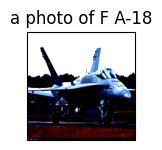

In [67]:
from numpy.lib import shape_base
import matplotlib.pyplot as plt

for batch in trainloader:
    images, texts, labels = batch
    # Print the first batch

    print("Image Path:", images[0].shape)
    print("Text Description:", texts[0])
    print(len(texts))
    print("Label: ", labels)
    print(labels.shape)
    print(torch.unique(labels).shape)


    plt.subplot(2, 4, 2)
    image = images[0].numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(f"{texts[0]}")
    plt.xticks([])
    plt.yticks([])

    break

# Loss and Optimizer


In [74]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("batch size:", BATCH_SIZE)
print("lr:", LR)
print("momentum:", MOMENTUM)
print("weight decay:", WEIGHT_DECAY)

batch size: 4
lr: 1e-05
momentum: 0.0
weight decay: 0


#Train and validation

In [69]:
def evaluate_model(model, weight, valloader):
    model.load_state_dict(torch.load(weight))
    model.eval()

    val_correct_top1 = 0
    val_correct_top3 = 0
    total_val_samples = len(valloader.dataset)

    with torch.no_grad():
        for val_batch in valloader:
            val_images, val_texts, val_labels = val_batch
            val_images = val_images.to(device)
            val_texts =  torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_list]).to(device)
            val_labels = val_labels.to(device)

            logits_per_image, _ = model(val_images, val_texts)

            # Top-1 accuracy
            val_top1_pred = logits_per_image.argmax(dim=1)
            val_correct_top1 += (val_top1_pred == val_labels).sum().item()

            # Top-3 accuracy
            _, val_top3_pred = logits_per_image.topk(3, dim=1)
            val_correct_top3 += val_top3_pred.eq(val_labels.view(-1, 1).expand_as(val_top3_pred)).sum().item()

    # Calculate accuracy
    val_top1_accuracy = val_correct_top1 / total_val_samples
    val_top3_accuracy = val_correct_top3 / total_val_samples

    print(f"Validation Top-1 Accuracy: {val_top1_accuracy * 100:.2f}%")
    print(f"Validation Top-3 Accuracy: {val_top3_accuracy * 100:.2f}%")

    return val_top1_accuracy, val_top3_accuracy

In [ ]:
best_te_loss = 1e5
best_ep = -1

train_losses = []
val_losses = []

early_stopping_patience = 5
early_stopping_counter = 0

for epoch in range(EPOCH):
    print(f"Epoch: {epoch+1}")

    # Training loop
    model.train()
    train_loss = 0
    step = 0
    pbar = tqdm(trainloader, total=len(trainloader))
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        images, texts, _ = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)

        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        actual_batch_size = images.size(0)
        ground_truth = torch.arange(actual_batch_size).to(device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        train_loss += total_loss.item()

        total_loss.backward()

        if device == "cpu":
            optimizer.step()
            scheduler.step()
        else :
            convert_models_to_fp32(model)
            optimizer.step()
            scheduler.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {total_loss.item():.4f}", refresh=True)
    train_loss /= step
    train_losses.append(train_loss)


    # Validation loop
    val_loss = 0
    step = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(valloader, total = len(valloader))
        for batch in test_pbar:
            step += 1
            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)

            logits_per_image, logits_per_text = model(images, texts)

            actual_batch_size = logits_per_image.size(0)
            ground_truth = torch.arange(actual_batch_size).to(device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth)) / 2
            val_loss += total_loss.item()

            test_pbar.set_description(f"Epoch {epoch+1}/{EPOCH}, Validation Loss: {total_loss.item():.4f}", refresh=True)
        val_loss /= step
        val_losses.append(val_loss)

    if val_loss < best_te_loss:
        best_te_loss = val_loss
        best_ep = epoch+1
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best epoch: {best_ep}, Best Validation loss: {best_te_loss}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
              print(f"Validation loss did not improve for {early_stopping_patience} epochs. Stopping early.")
              break

    print(f"epoch {epoch+1}, Train Loss {train_loss}, Validation Loss {val_loss}")

top1, top3 = evaluate_model(model, "best_model.pt", valloader)

plt.plot(range(1, epoch+2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'StandfordCats_9_n.pth')
shutil.copy('StandfordCats_9_n.pth', '/content/drive/MyDrive/Study/DL_CLIP/experiment_model/StandfordCats_9_n.pth')

# Evaluate with the Validation set


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

val_correct_top1 = 0
val_correct_top3 = 0
total_val_samples = len(valloader.dataset)

with torch.no_grad():
    for val_batch in valloader:
        val_images, val_texts, val_labels = val_batch
        val_images = val_images.to(device)
        val_texts =  torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_list]).to(device)
        val_labels = val_labels.to(device)

        logits_per_image, _ = model(val_images, val_texts)

        # Top-1 accuracy
        val_top1_pred = logits_per_image.argmax(dim=1)
        val_correct_top1 += (val_top1_pred == val_labels).sum().item()

        # Top-3 accuracy
        _, val_top3_pred = logits_per_image.topk(3, dim=1)
        val_correct_top3 += val_top3_pred.eq(val_labels.view(-1, 1).expand_as(val_top3_pred)).sum().item()

# Calculate accuracy
val_top1_accuracy = val_correct_top1 / total_val_samples
val_top3_accuracy = val_correct_top3 / total_val_samples

print(f"Validation Top-1 Accuracy: {val_top1_accuracy * 100:.2f}%")
print(f"Validation Top-3 Accuracy: {val_top3_accuracy * 100:.2f}%")

Validation Top-1 Accuracy: 10.59%
Validation Top-3 Accuracy: 26.79%
